In [1]:
import os
import scipy
import nltk
import gensim
import pandas as pd
import numpy as np
from gensim.models.fasttext import FastText
from scipy.cluster.hierarchy import linkage, dendrogram
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

In [34]:
import matplotlib.pylab as plt
%matplotlib inline
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (18, 6)

In [3]:
import logging
logging.root.handlers = []  # Jupyter messes up logging so needs a reset
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

In [4]:
df = pd.read_pickle('metatable_preprocessed.pkl')

In [5]:
df.head()

,filename,title,year,author,years_of_life,time_summary,time_book,name,username,tradition_country,tradition,country,text,text_tokenized,text_pymystem_list,text_pymystem_pos_list,text_pymystem,text_pymystem_pos
0,texts/ablesimov_melnik_koldun_obmanshchik_i_sv...,"Мельник — колдун, обманщик и сват",NaN,Аблесимов,1742–1783,Читается за 6 минут,40 мин,NaN,NaN,Русская литература->18 век,Русская литература,18 век,На краю леса перед мельницей мельник Фаддей ст...,"[на, краю, леса, перед, мельницей, мельник, фа...","[край, лес, мельница, мельник, фаддей, строгат...","[край_NOUN, лес_NOUN, мельница_NOUN, мельник_N...",край лес мельница мельник фаддей строгать доск...,край_NOUN лес_NOUN мельница_NOUN мельник_NOUN ...
1,texts/abramov_o_chem_plachut_loshadi.txt,О чём плачут лошади,1972.0,Абрамов,1920–1983,Читается за 2 минуты,11 мин,Сергей Симиненко,siminenko,Русская литература->Советская,Русская литература,Советская,"Рассказчик любит лошадей, которым живётся очен...","[рассказчик, любит, лошадей, которым, живётся,...","[рассказчик, любить, лошадь, который, житься, ...","[рассказчик_NOUN, любить_VERB, лошадь_NOUN, ко...",рассказчик любить лошадь который житься очень ...,рассказчик_NOUN любить_VERB лошадь_NOUN которы...
2,texts/abramov_alka.txt,Алька,1972.0,Абрамов,1920–1983,Читается за 6 минут,"1,5 ч",NaN,NaN,Русская литература->Советская,Русская литература,Советская,Лето. В последний раз главная героиня Аля Амос...,"[лето, последний, раз, главная, героиня, аля, ...","[лето, последний, главный, героиня, аля, амосо...","[лето_NOUN, последний_ADJ, главный_ADJ, героин...",лето последний главный героиня аля амосов родн...,лето_NOUN последний_ADJ главный_ADJ героиня_NO...
3,texts/abramov_bratja_i_sestry.txt,Братья и сёстры,1972.0,Абрамов,1920–1983,Читается за 3 минуты,7 ч,NaN,NaN,Русская литература->Советская,Русская литература,Советская,Пекашинский мужик Степан Андреянович Ставров с...,"[пекашинский, мужик, степан, андреянович, став...","[пекашинский, мужик, степан, андреянович, став...","[пекашинский_ADJ, мужик_NOUN, степан_NOUN, анд...",пекашинский мужик степан андреянович ставр сру...,пекашинский_ADJ мужик_NOUN степан_NOUN андреян...
4,texts/abe_zhencshina_v_peskah.txt,Женщина в песках,1962.0,Абэ,1924–1993,Читается за 9 минут,4 ч,В. С. Санович,sanovich,Прочая литература->Японская,Прочая литература,Японская,Однажды в августе человек отправляется в трехд...,"[однажды, августе, человек, отправляется, трех...","[однажды, август, человек, отправляться, трехд...","[однажды_ADV, август_NOUN, человек_NOUN, отпра...",однажды август человек отправляться трехдневны...,однажды_ADV август_NOUN человек_NOUN отправлят...


In [6]:
df.groupby(['tradition'])['tradition'].count()

tradition
Американская литература          201
Античная литература               49
Британская литература             21
Европейская литература           543
Латиноамериканская литература     14
Прочая восточная литература        7
Прочая европейская литература     24
Прочая литература                113
Русская литература               499
Скандинавская литература          39
Name: tradition, dtype: int64

Text(0.5,1,'Texts by traditions')

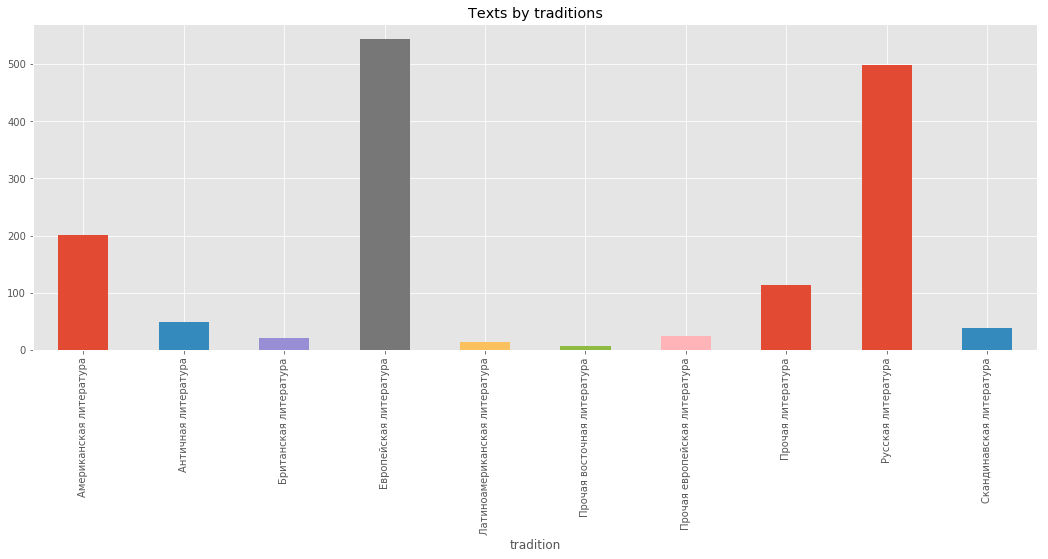

In [45]:
df.groupby(['tradition'])['tradition'].count().plot(kind="bar")
plt.title('Texts by traditions')

In [8]:
traditions = ['Американская литература', 'Античная литература',
       'Британская литература', 'Европейская литература',
       'Латиноамериканская литература', 'Прочая восточная литература',
       'Прочая европейская литература', 'Прочая литература',
       'Русская литература', 'Скандинавская литература']

In [9]:
def get_joined_texts(df, col_text, col_label, labels):
    if isinstance(df.loc[1, col_text], str):
        data_type = 'str'
        texts = {label: '' for label in labels}
    elif isinstance(df.loc[1, col_text], list):
        data_type = 'list'
        texts = {label: [] for label in labels}

    for i in df.index:
        res_label = df.loc[i, col_label]
        if res_label in texts:
            res_text = df.loc[i, col_text]
            if data_type == 'str':
                texts[res_label] += ' {}'.format(res_text)
            elif data_type == 'list':
                texts[res_label] += res_text
    
    return list(texts.keys()), list(texts.values())

In [10]:
tokenizer = nltk.word_tokenize
COUNT_VECT = CountVectorizer(tokenizer=tokenizer)
TF_VECT = TfidfVectorizer(tokenizer=tokenizer)

In [11]:
def plot_dendrogram(vectorizer, labels, texts, title):
    if vectorizer:
        if vectorizer == 'TF':
            vect = COUNT_VECT
        elif vectorizer == 'Count':
            vect = TF_VECT
    
        transformed = scipy.sparse.csr_matrix.toarray(vect.fit_transform(texts))
        res = linkage(transformed, method='complete')
        plt.title(vectorizer + '_vectorizer ' + title)
    else:
        res = linkage(texts, method='complete')
        plt.title('Word2vec')

    dendrogram(res, labels=labels, leaf_rotation=90)
    plt.show()

In [13]:
%%time

tradition_labels, tradition_texts = get_joined_texts(df, 'text', 'tradition', traditions)
tradition_lemmatized_labels, tradition_lemmatized = get_joined_texts(df, 'text_pymystem', 'tradition', traditions)
tradition_lemmatized_pos_labels, tradition_lemmatized_pos = get_joined_texts(df, 'text_pymystem_pos', 
                                                                             'tradition', traditions)

CPU times: user 3.18 s, sys: 722 ms, total: 3.9 s
Wall time: 3.9 s


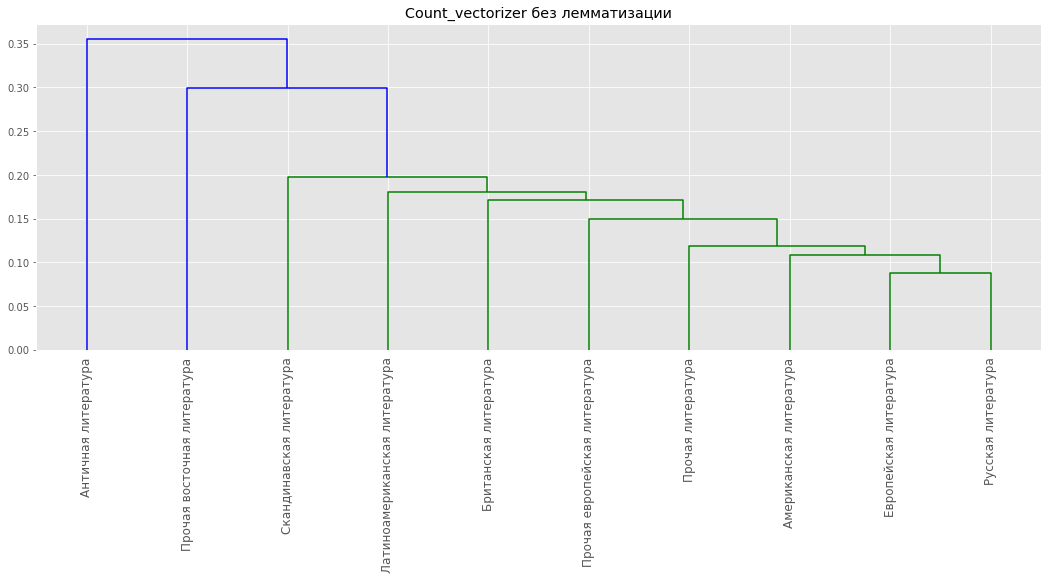

In [46]:
plot_dendrogram('Count', tradition_labels, tradition_texts, 'без лемматизации')

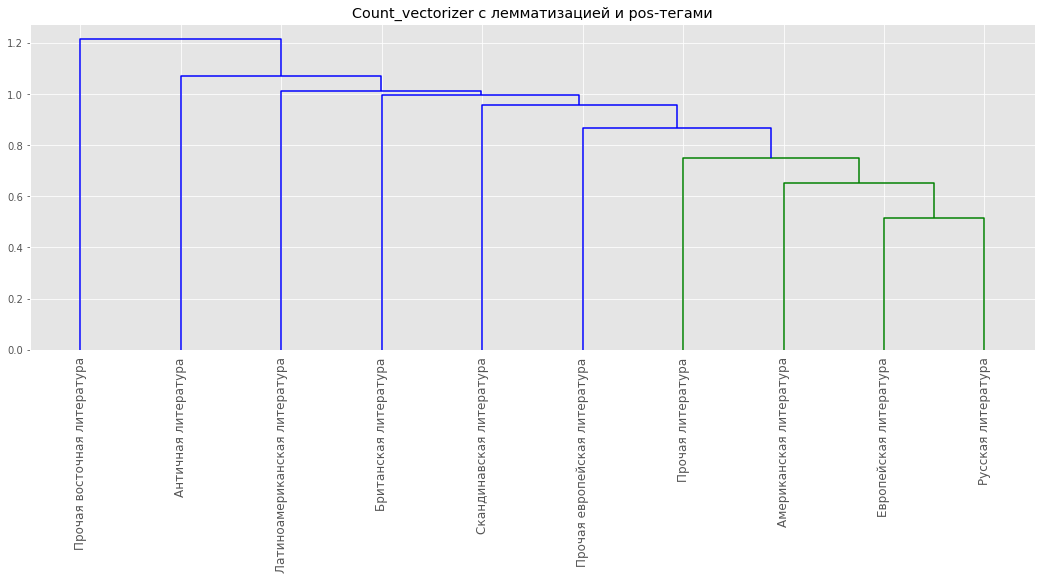

In [47]:
plot_dendrogram('Count', tradition_lemmatized_pos_labels, tradition_lemmatized_pos, 'с лемматизацией и pos-тегами')

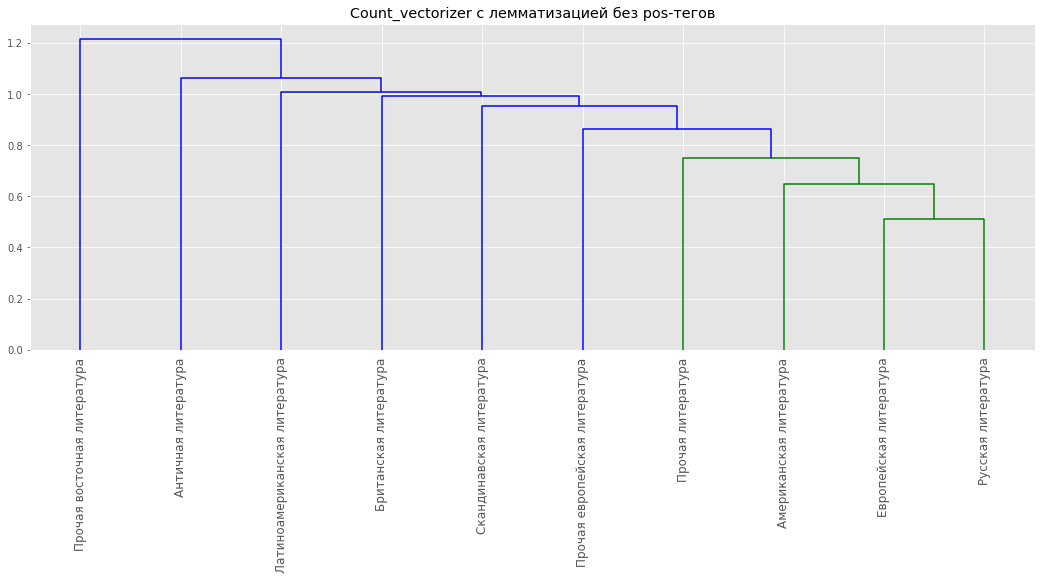

In [48]:
plot_dendrogram('Count', tradition_lemmatized_labels, tradition_lemmatized, 'с лемматизацией без pos-тегов')

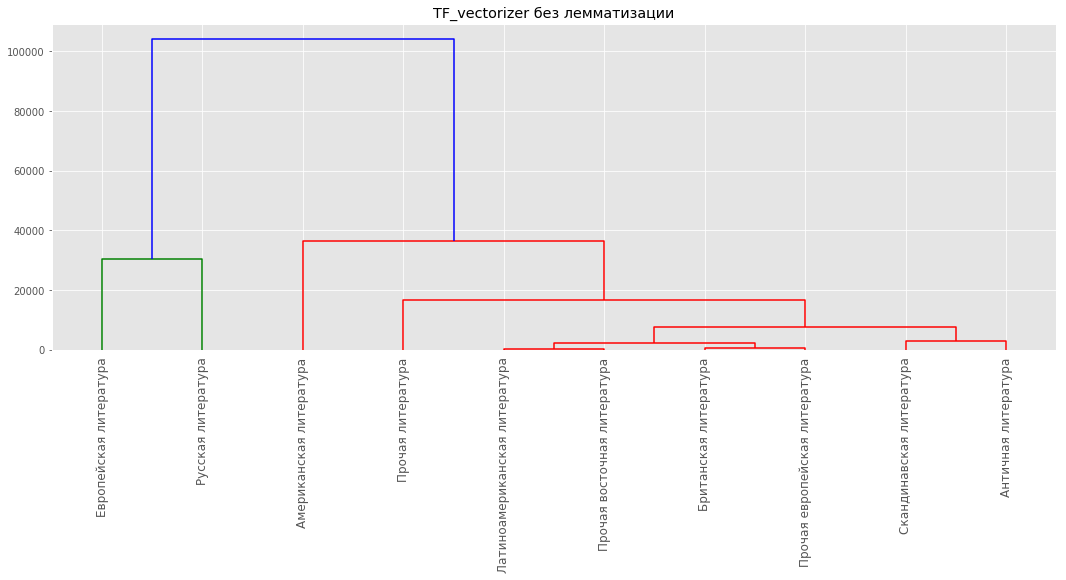

In [49]:
plot_dendrogram('TF', tradition_labels, tradition_texts, 'без лемматизации')

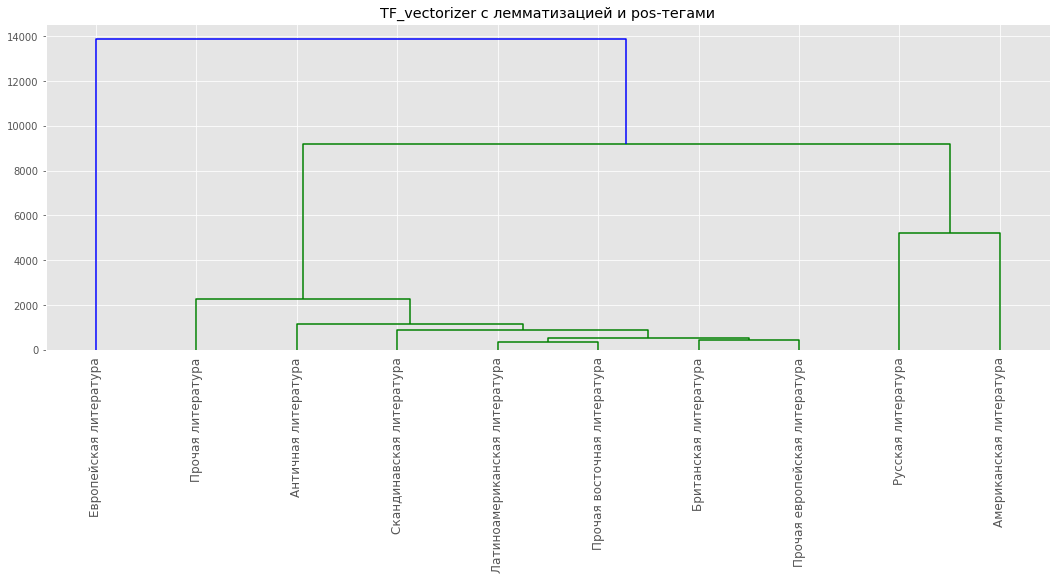

In [50]:
plot_dendrogram('TF', tradition_lemmatized_pos_labels, tradition_lemmatized_pos, 'c лемматизацией и pos-тегами')

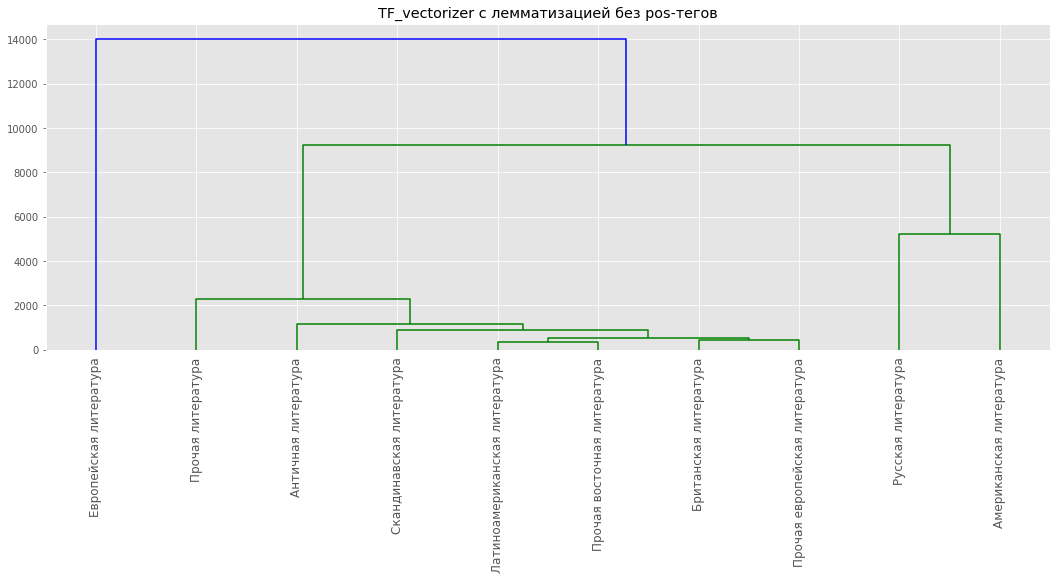

In [51]:
plot_dendrogram('TF', tradition_lemmatized_labels, tradition_lemmatized, 'c лемматизацией без pos-тегов')

In [20]:
def word_averaging(wv, words):
    all_words, mean = set(), []
    
    for word in words:
        if isinstance(word, np.ndarray):
            mean.append(word)
        elif word in wv.vocab:
            mean.append(wv.vectors_norm[wv.vocab[word].index])
            all_words.add(wv.vocab[word].index)

    if not mean:
        logging.warning("cannot compute similarity with no input %s", words)
        # FIXME: remove these examples in pre-processing
        return np.zeros(wv.layer1_size,)

    mean = gensim.matutils.unitvec(np.array(mean).mean(axis=0)).astype(np.float32)
    return mean

def word_averaging_list(wv, text_list):
    return np.vstack([word_averaging(wv, review) for review in text_list ])

In [21]:
%%time

path = '/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model'
model = FastText.load(os.getcwd() + path)
model.init_sims(replace=True)

2018-09-29 13:28:08,552 : INFO : loading FastText object from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model
2018-09-29 13:28:12,023 : INFO : loading wv recursively from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.* with mmap=None
2018-09-29 13:28:12,028 : INFO : loading syn0_vocab from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0_vocab.npy with mmap=None
2018-09-29 13:28:12,797 : INFO : loading syn0 from /media/zu_ann/OS/Users/zu_ann/Yandex.Disk/HSE/DH/dh/araneum_none_fasttextskipgram_300_5_2018/araneum_none_fasttextskipgram_300_5_2018.model.wv.syn0.npy with mmap=None
2018-09-29 13:28:13,702 : INFO : setting ignored attribute syn0norm to None
2018-09-29 13:28:13,707 : INFO : setting ignored attr

CPU times: user 10.8 s, sys: 5.68 s, total: 16.5 s
Wall time: 39 s


In [22]:
%%time

tradition_lemmatized_list_labels, tradition_lemmatized_list = get_joined_texts(df, 'text_pymystem_list',
                                                                               'tradition', traditions)

CPU times: user 95.1 ms, sys: 15.3 ms, total: 110 ms
Wall time: 198 ms


In [23]:
%%time

tradition_vec = word_averaging_list(model.wv, tradition_lemmatized_list)

CPU times: user 3.77 s, sys: 643 ms, total: 4.41 s
Wall time: 4.42 s


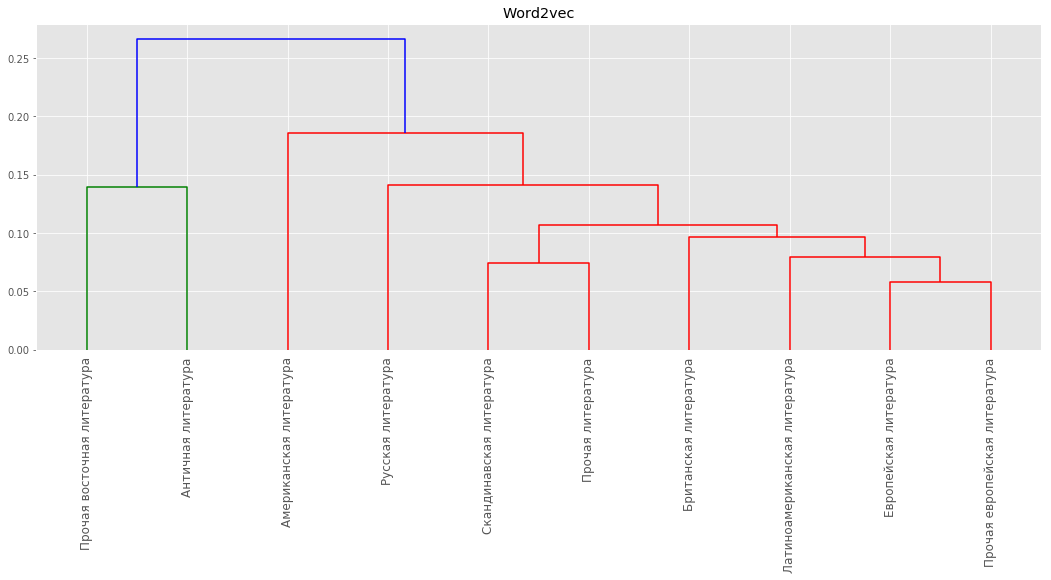

In [52]:
plot_dendrogram(None, tradition_lemmatized_list_labels, tradition_vec, None)

In [25]:
df.groupby(['country'])['country'].count()

country
18 век              39
19 век             129
Австралийская        8
Австрийская         22
Аргентинская         6
Армянская            1
Белорусская          7
Бельгийская          6
Бразильская          3
Британская         156
Гватемальская        1
Грузинская           1
Датская             10
Древнегреческая     34
Древнеримская       15
Древность            7
Еврейская           14
Индийская           16
Ирландская           5
Исландская           1
Испанская           27
Итальянская         48
Китайская           42
Колумбийская         2
Кубинская            1
Немецкая            81
Нидерландская        1
Норвежская          12
Персидская           4
Польская            18
Португальская        1
США                201
Советская          273
Современная         51
Турецкая             1
Украинская           1
Финская              1
Французская        183
Чешская              4
Чилийская            1
Шведская            15
Швейцарская         11
Шотландская         16
Юго

Text(0.5,1,'Texts by countries')

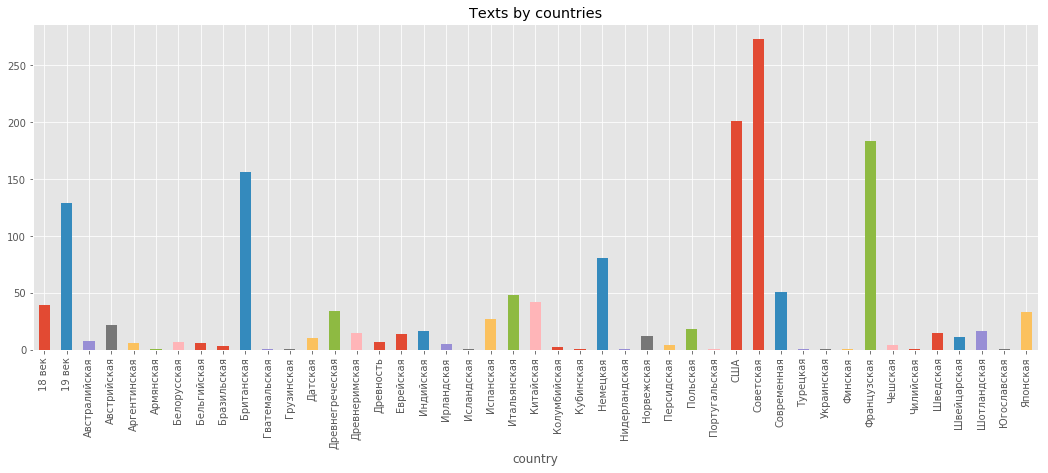

In [35]:
df.groupby(['country'])['country'].count().plot(kind="bar")
plt.title('Texts by countries')

In [27]:
countries = ['18 век', '19 век', 'Австралийская', 'Австрийская', 'Аргентинская',
       'Армянская', 'Белорусская', 'Бельгийская', 'Бразильская', 'Британская',
       'Гватемальская', 'Грузинская', 'Датская', 'Древнегреческая',
       'Древнеримская', 'Древность', 'Еврейская', 'Индийская', 'Ирландская',
       'Исландская', 'Испанская', 'Итальянская', 'Китайская', 'Колумбийская',
       'Кубинская', 'Немецкая', 'Нидерландская', 'Норвежская', 'Персидская',
       'Польская', 'Португальская', 'США', 'Советская', 'Современная',
       'Турецкая', 'Украинская', 'Финская', 'Французская', 'Чешская',
       'Чилийская', 'Шведская', 'Швейцарская', 'Шотландская', 'Югославская',
       'Японская']

In [28]:
%%time

country_labels, country_texts = get_joined_texts(df, 'text', 'country', countries)
country_lemmatized_labels, country_lemmatized = get_joined_texts(df, 'text_pymystem', 'country', countries)
country_lemmatized_pos_labels, country_lemmatized_pos = get_joined_texts(df, 'text_pymystem_pos',
                                                                         'country', countries)

CPU times: user 1.71 s, sys: 134 ms, total: 1.84 s
Wall time: 2.6 s


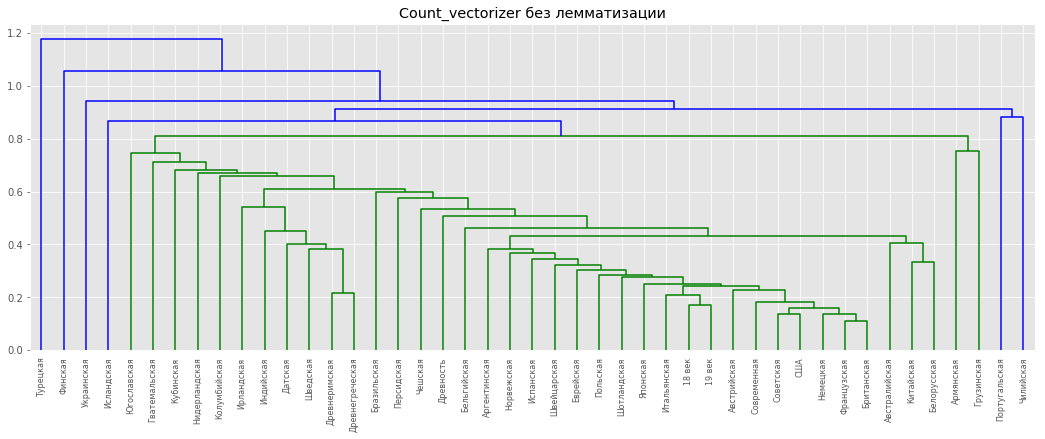

In [36]:
plot_dendrogram('Count', country_labels, country_texts, 'без лемматизации')

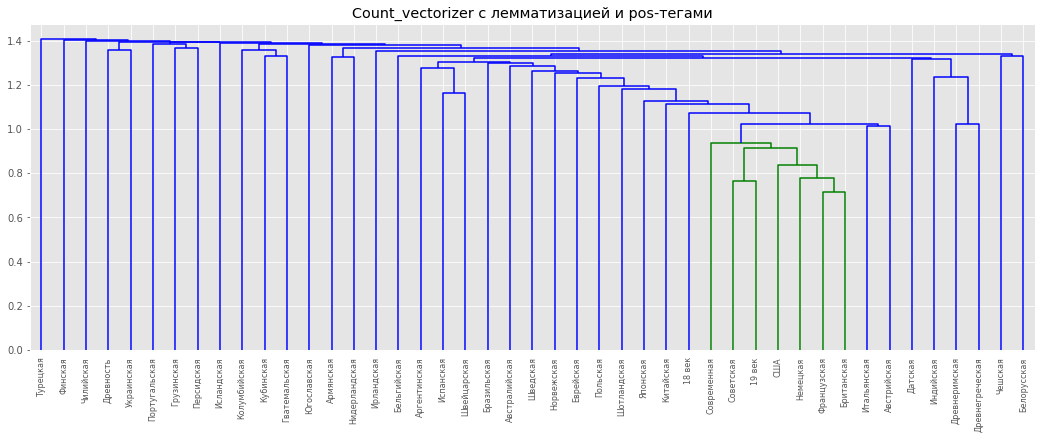

In [37]:
plot_dendrogram('Count', country_lemmatized_pos_labels, country_lemmatized_pos, 'с лемматизацией и pos-тегами')

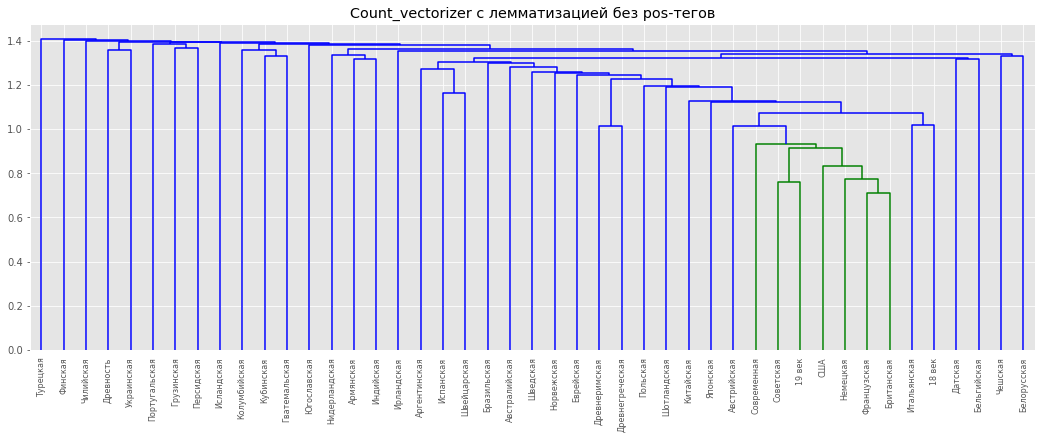

In [38]:
plot_dendrogram('Count', country_lemmatized_labels, country_lemmatized, 'с лемматизацией без pos-тегов')

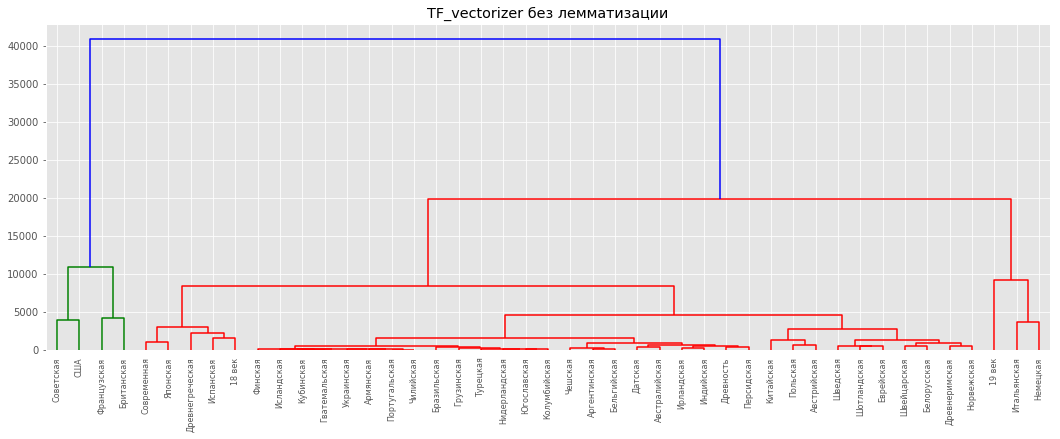

In [39]:
plot_dendrogram('TF', country_labels, country_texts, 'без лемматизации')

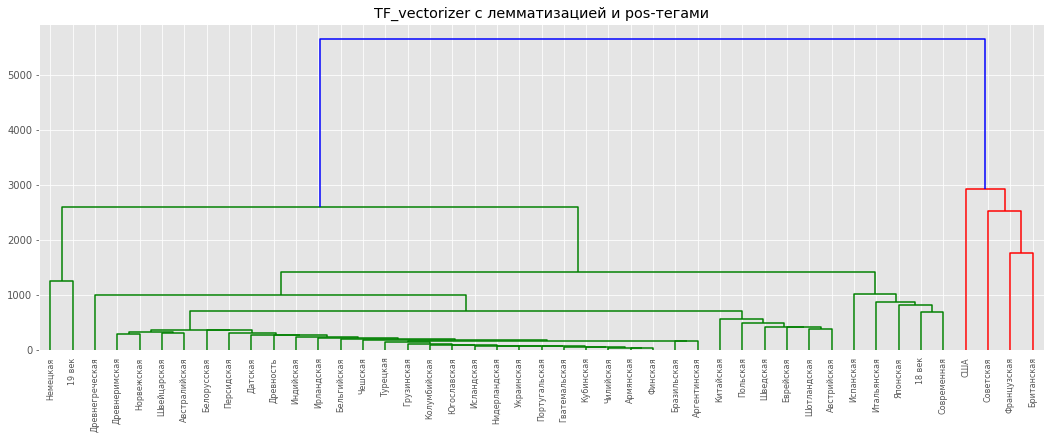

In [40]:
plot_dendrogram('TF', country_lemmatized_pos_labels, country_lemmatized_pos, 'c лемматизацией и pos-тегами')

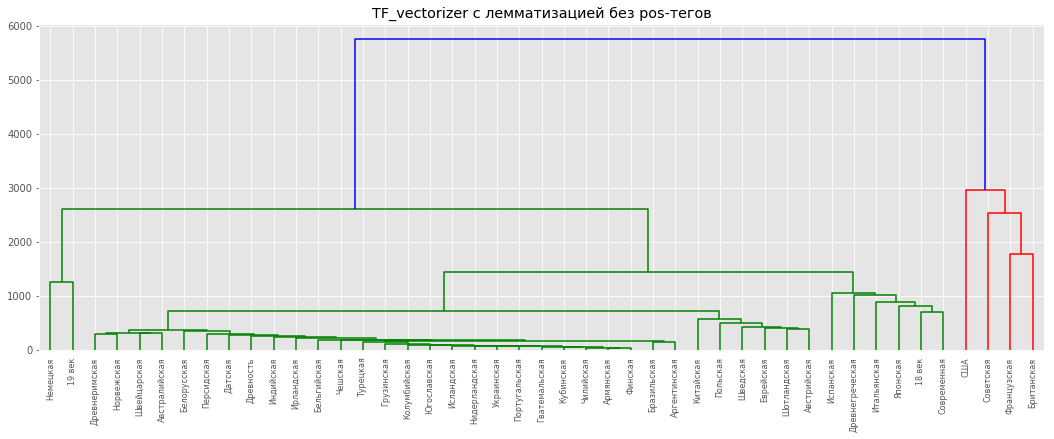

In [41]:
plot_dendrogram('TF', country_lemmatized_labels, country_lemmatized, 'c лемматизацией без pos-тегов')

In [42]:
%%time

country_lemmatized_list_labels, country_lemmatized_list = get_joined_texts(df, 'text_pymystem_list',
                                                                            'country', countries)

CPU times: user 154 ms, sys: 144 ms, total: 299 ms
Wall time: 120 ms


In [43]:
%%time

country_vec = word_averaging_list(model.wv, country_lemmatized_list)

CPU times: user 3.99 s, sys: 560 ms, total: 4.55 s
Wall time: 4.66 s


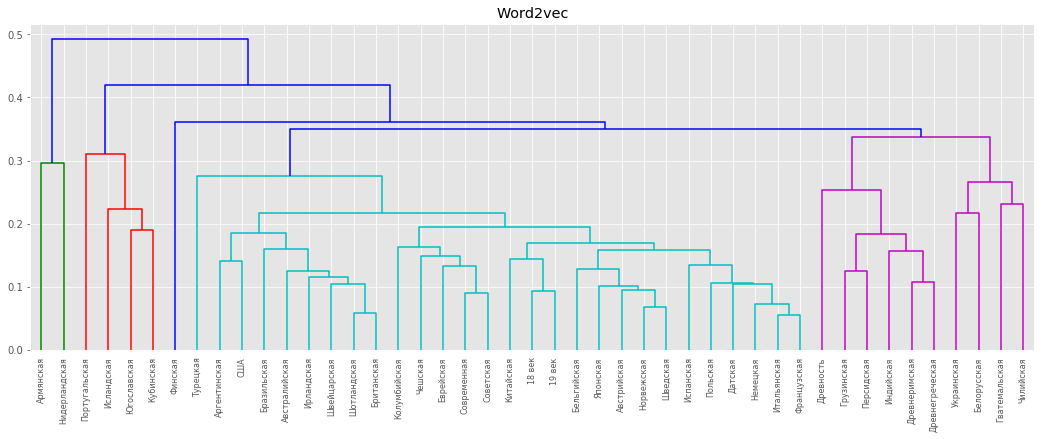

In [44]:
plot_dendrogram(None, country_lemmatized_list_labels, country_vec, None)